In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt

import pdb
from tqdm import tqdm

from torchsummary import summary

%matplotlib inline

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torchType = torch.float32

### Data

In [3]:
train_batch_size = 200
val_dataset = 10000
val_batch_size = 100
test_batch_size = 10

In [4]:
class Dataset():
    def __init__(self,):
        train = datasets.MNIST(root='./data/mnist', download=True)
        data_train = train.train_data.type(torchType).to(device)
        labels_train = train.train_labels.type(torchType).to(device)
        
        test = datasets.MNIST(root='./data/mnist', download=True, train=False)
        data_test = test.test_data.type(torchType).to(device)
        labels_test = test.test_labels.type(torchType).to(device)
        
        validation = data_train[:val_dataset].data
        validation_labels = labels_train[:val_dataset].data
        
        train = data_train[val_dataset:].data
        train_labels = labels_train[val_dataset:].data
        
        self.test = data_test.data
        self.test_labels = labels_test.data

        train_data = []
        for i in range(train.shape[0]):
            train_data.append([train[i], train_labels[i]])
        self.train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=train_batch_size, shuffle=True)

        val_data = []
        for i in range(validation.shape[0]):
            val_data.append([validation[i], validation_labels[i]])
        self.val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=val_batch_size, shuffle=False)

        test_data = []
        for i in range(self.test.shape[0]):
            test_data.append([self.test[i], self.test_labels[i]])
        self.test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=test_batch_size, shuffle=False)
    
    def next_train_batch(self):
        for train_batch in self.train_dataloader:
            batch = train_batch[0]
            labels = train_batch[1]
            batch = torch.distributions.Binomial(probs=batch).sample()
            batch = batch.view([-1, 1, 28, 28])
            yield batch, labels

    def next_val_batch(self):
        for val_batch in self.val_dataloader:
            batch = val_batch[0]
            labels = val_batch[1]
            batch = batch.view([-1, 1, 28, 28])
            yield batch, labels

    def next_test_batch(self):
        for test_batch in self.test_dataloader:
            batch = test_batch[0]
            labels = test_batch[1]
            batch = torch.distributions.Binomial(probs=batch).sample()
            batch = batch.view([-1, 1, 28, 28])
            yield batch, labels

In [5]:
dataset = Dataset()

/home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


### NN definition

In [6]:
num_epoches = 201

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=2, padding=2)
        self.linear1 = nn.Linear(in_features=1024, out_features=256)
        self.linear2 = nn.Linear(in_features=256, out_features=32)

    def forward(self, x):
        h1 = torch.relu(self.conv1(x))
        h2 = torch.relu(self.conv2(h1))
        h3 = torch.relu(self.conv3(h2))
        h3_flat = h3.view(h3.shape[0], -1)
        h4 = torch.relu(self.linear1(h3_flat))
        h5 = torch.relu(self.linear2(h4))
        return h5

In [8]:
model = Net().to(device)

In [9]:
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             416
            Conv2d-2             [-1, 32, 7, 7]          12,832
            Conv2d-3             [-1, 64, 4, 4]          51,264
            Linear-4                  [-1, 256]         262,400
            Linear-5                   [-1, 32]           8,224
Total params: 335,136
Trainable params: 335,136
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 1.28
Estimated Total Size (MB): 1.33
----------------------------------------------------------------


### Bayesian last layer definition

In [10]:
last_weight_mu = nn.Parameter(torch.randn((32, 10), device=device, dtype=torchType))
last_weight_logvar = nn.Parameter(torch.randn((32, 10), device=device, dtype=torchType))

last_bias_mu = nn.Parameter(torch.randn((1, 10), device=device, dtype=torchType))
last_bias_logvar = nn.Parameter(torch.randn((1, 10), device=device, dtype=torchType))

### Define optimizer

In [11]:
params = list(model.parameters()) + [last_weight_mu, last_weight_logvar] + [last_bias_mu, last_bias_logvar]
optimizer = torch.optim.Adam(params)

### Training

In [12]:
std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torchType),
                                       scale=torch.tensor(1., device=device, dtype=torchType),)

In [13]:
for ep in tqdm(range(num_epoches)):
    for x_train, y_train_labels in dataset.next_train_batch():
        emb = model(x_train)
        last_weight = last_weight_mu + std_normal.sample(last_weight_mu.shape) * torch.exp(0.5 * last_weight_logvar)
        last_bias = last_bias_mu + std_normal.sample(last_bias_mu.shape) * torch.exp(0.5 * last_bias_logvar)
        
        logits = emb @ last_weight + last_bias
        log_likelihood = torch.distributions.Categorical(logits=logits).log_prob(y_train_labels).sum()
    
        KL = (0.5 * (last_weight_logvar + torch.exp(last_weight_logvar) + last_weight_mu ** 2 - 1.)).mean() \
                        + (0.5 * (last_bias_logvar + torch.exp(last_bias_logvar) + last_bias_mu ** 2 - 1.)).mean()
        
        elbo = log_likelihood - KL
        (-elbo).backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
    if ep % 10 == 0:
        print(f'ELBO value is {elbo.cpu().detach().numpy()} on epoch number {ep}')
        acc_total = []
        with torch.no_grad():
            for x_val, y_val_labels in dataset.next_val_batch():
                emb = model(x_val)
                last_weight = last_weight_mu
                last_bias = last_bias_mu
                logits = emb @ last_weight + last_bias
                probs = torch.softmax(logits, dim=-1)
                y_pred = torch.argmax(probs, dim=-1)
                acc = (y_pred==y_val_labels).to(torchType).cpu().mean().numpy()
                acc_total.append(acc)
        
        print(f"Mean validation accuracy at epoch number {ep} is {np.array(acc_total).mean()}")

  0%|          | 1/201 [00:01<03:21,  1.01s/it]

ELBO value is -224.30621337890625 on epoch number 0
Mean validation accuracy at epoch number 0 is 0.8569998741149902


  5%|▌         | 11/201 [00:10<02:57,  1.07it/s]

ELBO value is -3.766533613204956 on epoch number 10
Mean validation accuracy at epoch number 10 is 0.9803999066352844


 10%|█         | 21/201 [00:19<02:48,  1.07it/s]

ELBO value is -0.8982030749320984 on epoch number 20
Mean validation accuracy at epoch number 20 is 0.9857999682426453


 15%|█▌        | 31/201 [00:28<02:36,  1.08it/s]

ELBO value is -6.066192626953125 on epoch number 30
Mean validation accuracy at epoch number 30 is 0.984499990940094


 20%|██        | 41/201 [00:37<02:27,  1.08it/s]

ELBO value is 1.3843533992767334 on epoch number 40
Mean validation accuracy at epoch number 40 is 0.984000027179718


 25%|██▌       | 51/201 [00:46<02:18,  1.08it/s]

ELBO value is 3.2316317558288574 on epoch number 50
Mean validation accuracy at epoch number 50 is 0.9838998913764954


 30%|███       | 61/201 [00:56<02:12,  1.06it/s]

ELBO value is 4.7551188468933105 on epoch number 60
Mean validation accuracy at epoch number 60 is 0.9865000247955322


 35%|███▌      | 71/201 [01:05<02:01,  1.07it/s]

ELBO value is 6.014176368713379 on epoch number 70
Mean validation accuracy at epoch number 70 is 0.9850999712944031


 40%|████      | 81/201 [01:14<01:51,  1.08it/s]

ELBO value is 8.36228084564209 on epoch number 80
Mean validation accuracy at epoch number 80 is 0.9869998693466187


 45%|████▌     | 91/201 [01:23<01:40,  1.09it/s]

ELBO value is 10.197303771972656 on epoch number 90
Mean validation accuracy at epoch number 90 is 0.9855999946594238


 50%|█████     | 101/201 [01:32<01:30,  1.11it/s]

ELBO value is 12.1316499710083 on epoch number 100
Mean validation accuracy at epoch number 100 is 0.9852998852729797


 55%|█████▌    | 111/201 [01:41<01:22,  1.09it/s]

ELBO value is 14.186659812927246 on epoch number 110
Mean validation accuracy at epoch number 110 is 0.9858999848365784


 60%|██████    | 121/201 [01:50<01:15,  1.06it/s]

ELBO value is 16.188690185546875 on epoch number 120
Mean validation accuracy at epoch number 120 is 0.9856000542640686


 65%|██████▌   | 131/201 [01:59<01:04,  1.09it/s]

ELBO value is 18.27794075012207 on epoch number 130
Mean validation accuracy at epoch number 130 is 0.986299991607666


 70%|███████   | 141/201 [02:08<00:54,  1.09it/s]

ELBO value is 20.584056854248047 on epoch number 140
Mean validation accuracy at epoch number 140 is 0.9849998950958252


 75%|███████▌  | 151/201 [02:17<00:45,  1.09it/s]

ELBO value is 22.81257438659668 on epoch number 150
Mean validation accuracy at epoch number 150 is 0.9861999750137329


 80%|████████  | 161/201 [02:27<00:36,  1.08it/s]

ELBO value is 25.033477783203125 on epoch number 160
Mean validation accuracy at epoch number 160 is 0.9857999682426453


 85%|████████▌ | 171/201 [02:36<00:27,  1.08it/s]

ELBO value is 27.35662841796875 on epoch number 170
Mean validation accuracy at epoch number 170 is 0.9866999983787537


 90%|█████████ | 181/201 [02:45<00:18,  1.08it/s]

ELBO value is 29.798282623291016 on epoch number 180
Mean validation accuracy at epoch number 180 is 0.9857999682426453


 95%|█████████▌| 191/201 [02:54<00:09,  1.09it/s]

ELBO value is 31.91039276123047 on epoch number 190
Mean validation accuracy at epoch number 190 is 0.9861999750137329


100%|██████████| 201/201 [03:03<00:00,  1.10it/s]

ELBO value is 34.6427001953125 on epoch number 200
Mean validation accuracy at epoch number 200 is 0.9864999651908875


### Inference

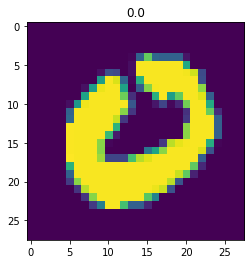

In [14]:
test_image_id = 25

test_image = dataset.test[test_image_id]
test_label = dataset.test_labels[test_image_id]

plt.title(f"{test_label.cpu().numpy()}")
plt.imshow(test_image.cpu().numpy());

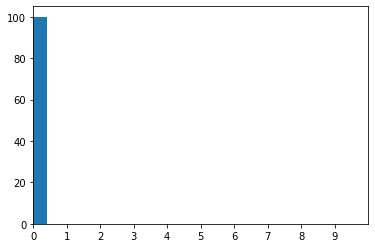

In [15]:
n_samples = 100

results = []
with torch.no_grad():
    for _ in range(n_samples):
        emb = model(test_image[None, None, ...])
        last_weight = last_weight_mu + std_normal.sample(last_weight_mu.shape) * torch.exp(0.5 * last_weight_logvar)
        last_bias = last_bias_mu + std_normal.sample(last_bias_mu.shape) * torch.exp(0.5 * last_bias_logvar)
        
        logits = emb @ last_weight + last_bias
        probs = torch.softmax(logits, dim=-1)
        y_pred = torch.argmax(probs, dim=-1)
        results.append(y_pred.cpu().item())
        

labels, counts = np.unique(results, return_counts=True)
plt.bar(labels, counts, align='center')
plt.xticks(ticks=np.arange(10))
plt.xlim((0, 10));

### Find digits with non-trivial distribution

----------------------------------------------------------------------------------------------------
92


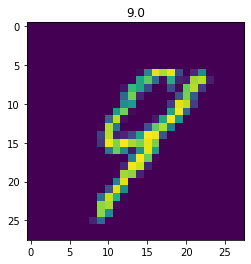

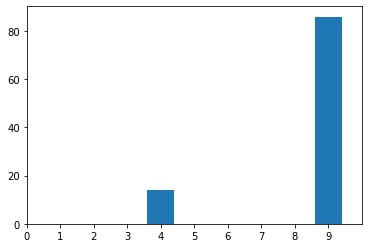

----------------------------------------------------------------------------------------------------
167


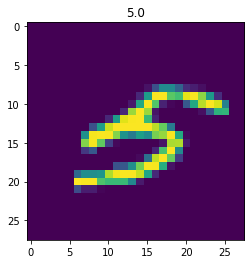

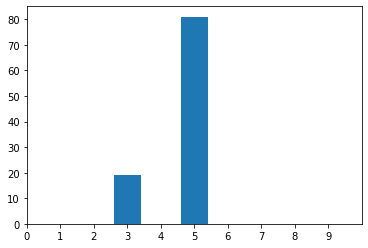

----------------------------------------------------------------------------------------------------
321


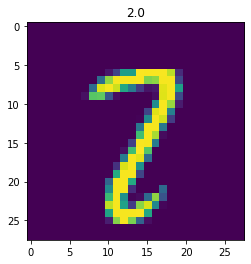

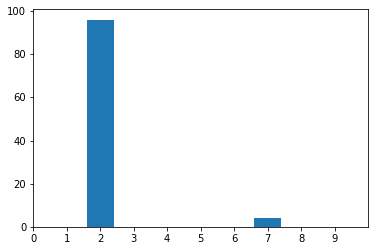

----------------------------------------------------------------------------------------------------
445


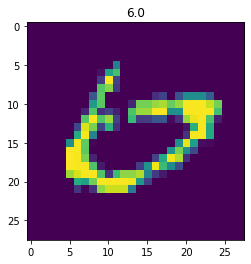

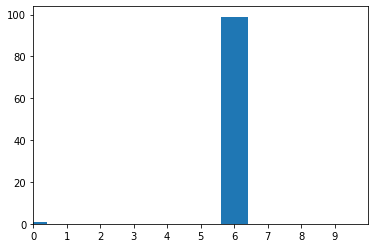

----------------------------------------------------------------------------------------------------
492


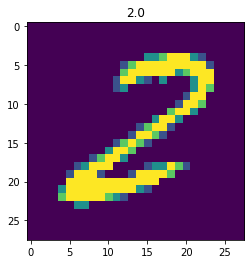

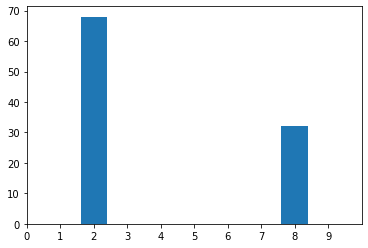

----------------------------------------------------------------------------------------------------
674


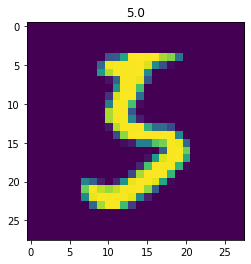

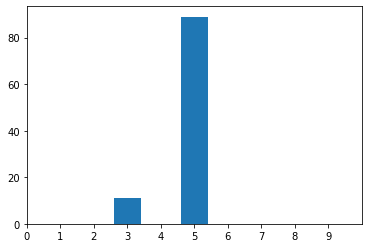

----------------------------------------------------------------------------------------------------
684


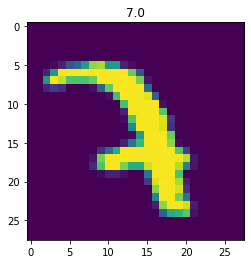

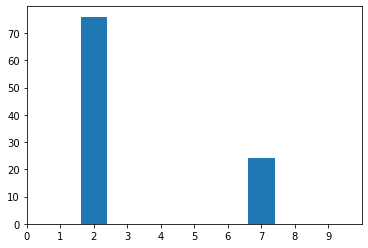

----------------------------------------------------------------------------------------------------
900


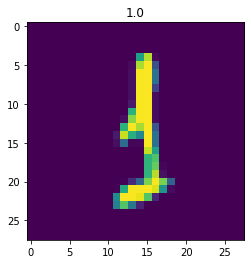

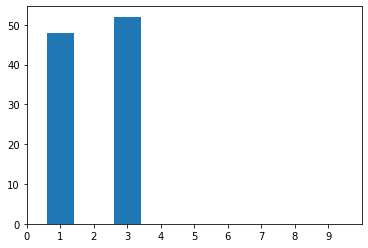

----------------------------------------------------------------------------------------------------
1138


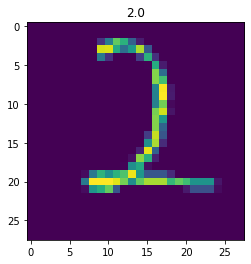

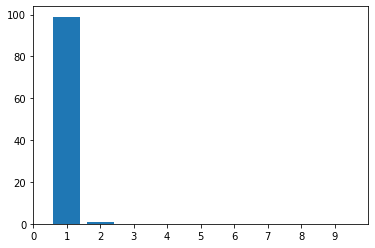

In [ ]:
n_samples = 100

for i in range(dataset.test.shape[0]):
    test_image = dataset.test[i]
    test_label = dataset.test_labels[i]
    plt.close()
    results = []
    with torch.no_grad():
        for _ in range(n_samples):
            emb = model(test_image[None, None, ...])
            last_weight = last_weight_mu + std_normal.sample(last_weight_mu.shape) * torch.exp(0.5 * last_weight_logvar)
            last_bias = last_bias_mu + std_normal.sample(last_bias_mu.shape) * torch.exp(0.5 * last_bias_logvar)

            logits = emb @ last_weight + last_bias
            probs = torch.softmax(logits, dim=-1)
            y_pred = torch.argmax(probs, dim=-1)
            results.append(y_pred.cpu().item())
    if np.unique(results).shape[0] > 1:
        print('-' * 100)
        print(i)
        plt.title(f"{test_label.cpu().numpy()}")
        plt.imshow(test_image.cpu().numpy());
        plt.show()
        
        labels, counts = np.unique(results, return_counts=True)
        plt.bar(labels, counts, align='center')
        plt.xticks(ticks=np.arange(10))
        plt.xlim((0, 10));
        plt.show();